#### Example 4 - Preprocessing a surface


Pit filling and swamp filling ... 

Take the previous mesh with random noise 

`Quagmire` allows the user to specify the number of downhill pathways to model landscape evolution. This is set using:

```python
mesh.downhill_neighbours = 1
mesh.update_height(height)
```

where an integer specifies the number of downhill neighbour nodes (receipients) that will receive a packet of information from a donor node. The `TopoMesh` object can also be initialised with:

```python
mesh = TopoMesh(DM, downhill_neighbours=1)
```

to specify the number of downhill neighbours (default is 2).

In this notebook we use a landscape function with many outflow points to examine the effect of varying the number of recipient nodes on catchment area, stream lengths, and outflow fluxes.


#### Notebook contents

- [1-2-3 downhill neighbours](#1-2-3-downhill-neighbours)
- [Upstream propogation](#Upstream-propogation)
- [Dense downhill matrices](#Dense-downhill-matrices)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import imread
from quagmire import tools as meshtools
%matplotlib inline

In [5]:
from quagmire import FlatMesh 
from quagmire import TopoMesh # all routines we need are within this class
from quagmire import SurfaceProcessMesh


minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,

spacingX = 0.05
spacingY = 0.05

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY, 1.)

DM = meshtools.create_DMPlex(x, y, simplices)
DM = meshtools.refine_DM(DM, refinement_steps=2)

mesh = SurfaceProcessMesh(DM)

x = mesh.coords[:,0]
y = mesh.coords[:,1]

print( "\nNumber of points in the triangulation: {}".format(mesh.npoints))

0 - Delaunay triangulation 0.565277s
0 - Calculate node weights and area 0.011408s
0 - Find boundaries 0.000526s
0 - cKDTree 0.022464s
0 - Construct neighbour cloud array 0.82219s
0 - Construct rbf weights 0.182585s

Number of points in the triangulation: 156925


In [6]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)+0.1

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 ## Less so
height  += 0.5 * (1.0-0.2*radius)
height  -= height.min()

## Add some pits 

hrand0 = np.where(np.random.random(height.shape)>0.995, -0.3, 0.0)

## Add smoothed random noise to make some "lakes" 

mesh._construct_rbf_weights(delta=mesh.delta*3.0)

randpts1 = np.where(np.random.random(height.shape)>0.995, -1.0, 0.0)
hrand1   = 10.0 * mesh.rbf_smoother(randpts1, iterations=10)

heightn = height + hrand0 + hrand1

mesh.downhill_neighbours = 2
mesh.update_height(heightn)

# let's use a rainfall proportional to height (any choice is ok)

rainfall = height**2
mesh.update_surface_processes(rainfall, np.zeros_like(rainfall))


0 - Compute slopes 0.186679s
0 - Build downhill matrices 0.669992s
 - Upstream area 0.32249s


In [7]:
low_points = mesh.identify_low_points()
low_point_coords = mesh.coords[low_points] 
low_points.nonzero()

(array([   0,    1,    2, ..., 1052, 1053, 1054]),)

In [8]:
height_before = mesh.height.copy()

In [9]:
import lavavu

lowsxyz = np.column_stack([mesh.tri.points[low_points], height[low_points]])
xyz  = np.column_stack([mesh.tri.points, height])
xyz2 = np.column_stack([mesh.tri.points, heightn])


lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

nodes = lv.points("nodes", pointsize=3.0, pointtype="shiny", colour="#448080", opacity=0.75)
nodes.vertices(lowsxyz)

tris = lv.triangles("triangles",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(xyz)
tris.indices(mesh.tri.simplices)
tris.values(height, label="height")
tris.values(rainfall, label="rainfall")
tris.values(heightn-height, label="perturbation")

# tris.colourmap("#990000 #FFFFFF #000099")
tris.colourmap("elevation")
cb = tris.colourbar()

tris2 = lv.triangles("triangles2",  wireframe=False, colour="#77ff88", opacity=1.0)
tris2.vertices(xyz2)
tris2.indices(mesh.tri.simplices)
tris2.values(heightn, label="heightn")
tris2.colourmap("elevation")
cb = tris2.colourbar()





# view the pole

# lv.translation(0.0, 0.0, -3.0)
# lv.rotation(-20, 0.0, 0.0)

lv.control.Panel()
lv.control.Range('specular', range=(0,1), step=0.1, value=0.4)
lv.control.Checkbox(property='axis')
lv.control.ObjectList()
tris.control.Checkbox(property="wireframe")
tris.control.List(["height", "rainfall", "perturbation"], property="colourby", value="orginal", command="redraw", label="Display:")
lv.control.show()

<IPython.core.display.Javascript object>

In [10]:
def compute_stream_power(mesh, slope, m=1, n=1):
    """
    Stream power law (q_s)
    """
    rainflux = mesh.rainfall_pattern
    rainfall = mesh.area * rainflux
    cumulative_rain = mesh.cumulative_flow(rainfall)    
    stream_power = cumulative_rain**m * slope**n
    stream_power[~mesh.bmask] = 0.0
    
    return stream_power

mesh.rainfall_pattern = rainfall

## 1. Smooth mesh 

mesh.update_height(height)
cumulative_rain = mesh.cumulative_flow(mesh.rainfall_pattern * mesh.area)
smooth_mesh_slope = mesh.slope.copy()

rbf_slope = mesh.rbf_smoother(mesh.slope)

stream_power = compute_stream_power(mesh, mesh.slope, m=1, n=1)

print("max stream power = {:.4f}, mean stream power = {:.4f}".format(stream_power.max(), stream_power.mean()))

## 2. Rough mesh

mesh.update_height(heightn)

cumulative_rain_n = mesh.cumulative_flow(mesh.rainfall_pattern * mesh.area)

stream_power_n = compute_stream_power(mesh, mesh.slope, m=1, n=1)

print("max stream power = {:.4f}, mean stream power = {:.4f}".format(stream_power_n.max(), stream_power_n.mean()))



0 - Compute slopes 0.201723s
0 - Build downhill matrices 0.71347s
max stream power = 0.5516, mean stream power = 0.0126
0 - Compute slopes 0.174818s
0 - Build downhill matrices 0.697269s
max stream power = 15.6833, mean stream power = 0.0048


In [11]:
import lavavu

points = np.column_stack([mesh.tri.points, height])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values(smooth_mesh_slope, "slope (smooth)")
tri1.values(mesh.slope, "slope (rough)")
tri1.values(cumulative_rain, "cumulative rain (smooth)")
tri1.values(cumulative_rain_n, "cumulative rain (rough)")
tri1.values(stream_power, "stream_power (smooth)")
tri1.values(stream_power_n, "stream_power (rough)")

tri1.colourmap("drywet", range=[0.0,1.0])
tri1.colourbar()

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(["slope (smooth)", 
                   "slope (rough)",
                   "cumulative rain (smooth)", 
                   "stream_power (smooth)", 
                   "cumulative rain (rough)", 
                   "stream_power (rough)" ], property="colourby", value="slope", command="redraw")
lv.control.show()

<IPython.core.display.Javascript object>

In [12]:
## Pit filling algorithm in quagmire

mesh1p = SurfaceProcessMesh(DM)
mesh1p.update_height(mesh.height)
hp = mesh1p.low_points_local_patch_fill(its=5, smoothing_steps=1)
mesh1p.update_height(hp)
mesh1p.update_surface_processes(mesh.rainfall_pattern, np.zeros_like(mesh.rainfall_pattern))


cumulative_rain_n1p = mesh1p.cumulative_flow(mesh.rainfall_pattern * mesh.area)
stream_power_n1p    = compute_stream_power(mesh1p, mesh1p.slope, m=1, n=1)


0 - Delaunay triangulation 0.573826s
0 - Calculate node weights and area 0.011848s
0 - Find boundaries 0.000164999999999s
0 - cKDTree 0.023704s
0 - Construct neighbour cloud array 0.80941s
0 - Construct rbf weights 0.183168s
0 - Compute slopes 0.186408s
0 - Build downhill matrices 0.773358s
Low point local patch fill
 - Partial rebuild of downhill matrices 0.669206s
 - Partial rebuild of downhill matrices 0.608774s
 - Partial rebuild of downhill matrices 0.592559s
 - Partial rebuild of downhill matrices 0.598702s
 - Partial rebuild of downhill matrices 0.589489s
Low point local patch fill  3.406985  seconds
0 - Compute slopes 0.176419s
0 - Build downhill matrices 0.677689s
 - Upstream area 0.293997s


In [13]:
import lavavu

points = np.column_stack([mesh.tri.points, height])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)

tri1.values(mesh1p.height-mesh.height,  "delta h pits")
tri1.values(mesh.slope,         "slope (rough)")
tri1.values(mesh1p.slope,       "slope (unpitted)")
tri1.values(cumulative_rain,    "cumulative rain")
tri1.values(cumulative_rain_n,  "cum-rain-rough")
tri1.values(cumulative_rain_n1p,"cum-rain-unpitted")

tri1.colourmap("drywet")
tri1.colourbar()

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(["delta h pits", 
                   "slope (unpitted)",
                   "slope (rough)",
                   "cumulative rain",
                   "cum-rain-rough",
                   "cum-rain-unpitted"], property="colourby", value="slope", command="redraw")
lv.control.show()

<IPython.core.display.Javascript object>

In [14]:
## Quagmire also has a swamp filling algorithm

mesh1s = SurfaceProcessMesh(DM)
mesh1s.update_height(mesh.height)

for i in range(0,20):
    hs = mesh1s.low_points_swamp_fill(ref_height=-0.01)
    
    # In parallel, we can't break if ANY processor has work to do (barrier / sync issue)
    low_points2 = mesh1s.identify_global_low_points()
    
    print("{} : {}".format(i,low_points2[0]))
    if low_points2[0] == 0:
        break
        

mesh1s.update_height(hs)

mesh1s.update_surface_processes(mesh.rainfall_pattern, np.zeros_like(mesh.rainfall_pattern))

cumulative_rain_n1s = mesh1s.cumulative_flow(mesh.rainfall_pattern * mesh.area)
stream_power_n1s    = compute_stream_power(mesh1s, mesh1p.slope, m=1, n=1)


0 - Delaunay triangulation 0.570095s
0 - Calculate node weights and area 0.010699s
0 - Find boundaries 0.000384s
0 - cKDTree 0.022592s
0 - Construct neighbour cloud array 0.76078s
0 - Construct rbf weights 0.196738s
0 - Compute slopes 0.176432s
0 - Build downhill matrices 0.710081s
64  iterations, time =  0.759921
Build low point catchments -  0.761028  seconds
0  Sort spills -  0.00935
0  Gather spill data -  0.000184999999998
0  Sort all spills -  0.001005
 - Partial rebuild of downhill matrices 0.713133s
Low point swamp fill  1.74061  seconds
0 : 663
140  iterations, time =  1.793467
Build low point catchments -  1.794111  seconds
0  Sort spills -  0.004084
0  Gather spill data -  0.000277000000001
0  Sort all spills -  0.000122999999999
 - Partial rebuild of downhill matrices 0.628136s
Low point swamp fill  2.522431  seconds
1 : 753
193  iterations, time =  2.284065
Build low point catchments -  2.2853  seconds
0  Sort spills -  0.002782
0  Gather spill data -  0.000204
0  Sort all

In [21]:
import lavavu

points = np.column_stack([mesh.tri.points, heightn])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)

tri1.values(np.log(cumulative_rain_n1s),"cum-rain-swamp")
tri1.values(np.log(cumulative_rain_n),  "cum-rain-rough")
tri1.values(np.log(cumulative_rain),    "cumulative rain")

tri1.colourmap("#BBEEBB #889988 #000099")
tri1.colourbar()

## Swamped

points = np.column_stack([mesh1s.tri.points, mesh1s.height-0.01])

tri2 = lv.triangles("triangles2", wireframe=False)
tri2.vertices(points)
tri2.indices(mesh1s.tri.simplices)

tri2.values(mesh1s.height-mesh.height,   "swamps")
tri2.values(np.ones_like(mesh1s.height), "blank")
tri2.values(np.log(cumulative_rain_n1s), "cum-rain-swamp")

tri2.colourmap("#003366:0.5, #000099:0.8, #000099")
tri2.colourbar()

lv.translation(0.0, 0.0, -19.915)
lv.rotation(-51.21, -1.618, -3.573)

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(["cum-rain-swamp",
                   "cumulative rain", 
                   "cum-rain-rough"
                   ], property="colourby", command="redraw")

tri2.control.List(["blank", "swamps", 
                   "cum-rain-swamp"], property="colourby", command="redraw")


lv.control.show()



<IPython.core.display.Javascript object>


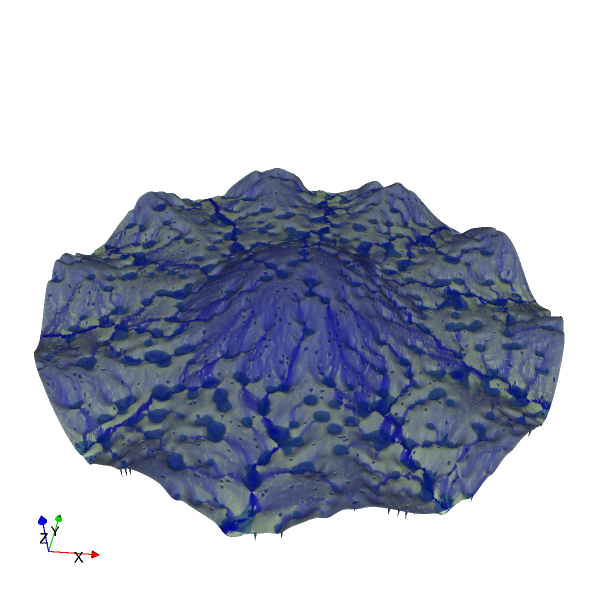

In [22]:
lv.display()

In [16]:
## Stream power / slope where the lakes / swamps are located:

In [17]:
import lavavu

points = np.column_stack([mesh.tri.points, heightn])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)

tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)

tri1.values(mesh.slope,    "slope (rough)")
tri1.values(mesh1s.slope,  "slope (swamp)")
tri1.values(mesh.slope-mesh1s.slope,  "delta slope")


tri1.colourmap("#444444 #777777 #FF8800", range=[0,1.0])
tri1.colourbar()

## Swamped

points = np.column_stack([mesh1s.tri.points, mesh1s.height-0.01])

tri2 = lv.triangles("triangles2", wireframe=False)
tri2.vertices(points)
tri2.indices(mesh1s.tri.simplices)

tri2.values(mesh1s.height-mesh.height,   "swamps")
tri2.values(np.ones_like(mesh1s.height), "blank")
tri2.values(np.log(cumulative_rain_n1s), "cum-rain-swamp")

tri2.colourmap("#003366:0.5, #000099:0.8, #000099")
tri2.colourbar()


lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(["slope (rough)",
                   "slope (swamp)", 
                   "delta slope" 
                   ], property="colourby", command="redraw")

tri2.control.List(["blank", "swamps", 
                   "cum-rain-swamp"], property="colourby", command="redraw")


lv.control.show()

<IPython.core.display.Javascript object>


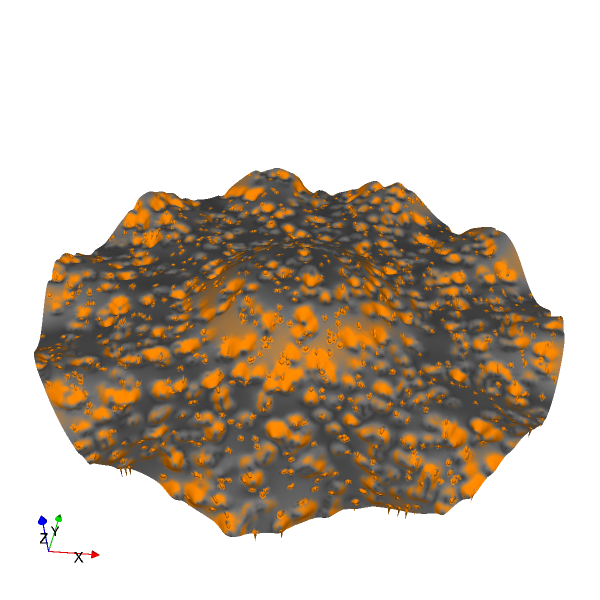

In [18]:
lv.display()

In [19]:
lv.camera()

lv.translation(0.0, 0.0, -19.915)
lv.rotation(-51.21, -1.618, -3.573)


{'rotation': [-0.432308495044708,
  0.000745128723792732,
  -0.0342144221067429,
  0.901],
 'translation': [0.0, 0.0, -19.915],
 'xyzrotation': [-51.21, -1.618, -3.573]}